In [1]:
import numpy as np, control as ct, matplotlib.pyplot as plt

### Lead-Lag controller$$G_C(s)=K_C\left(\frac{s+\frac{1}{T_1}}{s+\frac{\gamma}{T_1}}\right)\left(\frac{s+\frac{1}{T_2}}{s+\frac{1}{\beta T_2}}\right)$$

1. Determine desired closed loop dominant poles based on specifications$$M_p = e^{-\pi\xi/\sqrt{1-\xi^2}}\qquad t_s = \frac{4}{\xi\omega_n}$$
2. Calculate angular defficiency for non-controlled system evaluated at a dominant pole
3. Let $\phi=180-\text{angular defficiency}$, determine $T_1$ and $\gamma$ such that$$\text{Angle}\left(\frac{s+\frac{1}{T_1}}{s+\frac{\gamma}{T_1}}\right) = \phi$$
4. Choose an apropriate $K_v$ and find $\beta$ $$K_v=\lim_{s\to0}sK_c\frac{\beta}{\gamma}G(s)$$
5. Choose T2 such that the root locus doesn't change too much

In [2]:
def lead_lag(*, sys: ct.TransferFunction, csi: float=None, ts: float=None, pole: float|complex=None, overshoot: float=None, err_v: float = None) -> ct.TransferFunction:
    if csi != None and ts != None:
        omega_n = 4/(ts*csi)
        omega_d = omega_n * np.sqrt(1-csi**2)
        p_dom = -csi*omega_n + 1j*omega_d
    elif pole != None:
        p_dom = pole
    elif overshoot != None and ts != None:
        csi = -np.log(overshoot)/np.sqrt(np.pi**2+np.log(overshoot)**2)
        omega_n = 4/(ts*csi)
        omega_d = omega_n * np.sqrt(1-csi**2)
        p_dom = -csi*omega_n + 1j*omega_d
    else:
        raise Exception(ValueError)
    
    if err_v == None:
        Kv = 80
    else:
        Kv = 1/err_v

    # Lead compensator zero cancels slowest plant pole
    z_lead = sorted([pole for pole in sys.poles() if pole != 0], key=lambda x: np.abs(x))[-1]

    # Calculate current angle and reduces it to first rotation
    lead_zero = ct.tf([1, -z_lead], 1)
    curr_angle = np.angle((sys*lead_zero)(p_dom))
    curr_angle %= 2*np.pi

    # Calculate lead compensator pole such that angle(sys*lead) evaluated at p_dom = 180°
    p_lead = p_dom.imag/(np.tan(np.pi-curr_angle)) + p_dom.real
    lead_zero_and_pole = ct.tf([1, -z_lead], [1, -p_lead])

    # Calculate Kc such that abs(sys*lead) evaluated at p_dom = 1
    Kc = 1/np.abs((lead_zero_and_pole*sys)(p_dom))
    lead = Kc*lead_zero_and_pole

    gamma = p_lead/z_lead

    # Solve for beta in Kv = lim_{s->0}[s*Kc*beta/gamma*sys]    
    beta = ct.minreal(Kv/(Kc/gamma*ct.tf([1, 0], 1)*sys), verbose=False)(0).real

    # Set tolerance values for angle and absolute value changes when adding lag compensator
    angle_tol = 2
    abs_tol = 0.05

    t2_range = np.linspace(1, 30, 100)

    for T2 in t2_range:
        lag = ct.tf([1, 1/T2], [1, 1/beta*T2])
        angle = np.angle(lag(p_dom), deg=True)
        abs_v = np.abs(lag(p_dom))
        if abs(1 - abs_v) <= abs_tol and abs(angle) <= angle_tol:
            break
    
    return lead*lag

In [3]:
overshoot = 0.1
ts = 1
Kv = 80

csi = -np.log(overshoot)/np.sqrt(np.pi**2+np.log(overshoot)**2)
omega_n = 4/(ts*csi)
omega_d = omega_n * np.sqrt(1-csi**2)
p_dom = -csi*omega_n + 1j*omega_d

In [4]:
gp = ct.tf(4, [1, 0.5, 0])
gp

TransferFunction(array([4]), array([1. , 0.5, 0. ]))

In [5]:
gc = lead_lag(sys=gp, pole=p_dom)
gc

TransferFunction(array([11.44609134+0.j, 10.3671565 +0.j,  2.32205542+0.j]), array([1.        , 8.17631605, 1.41052843]))

/home/nikolas/.local/lib/python3.10/site-packages/control/statesp.py:114: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(data, dtype=float)


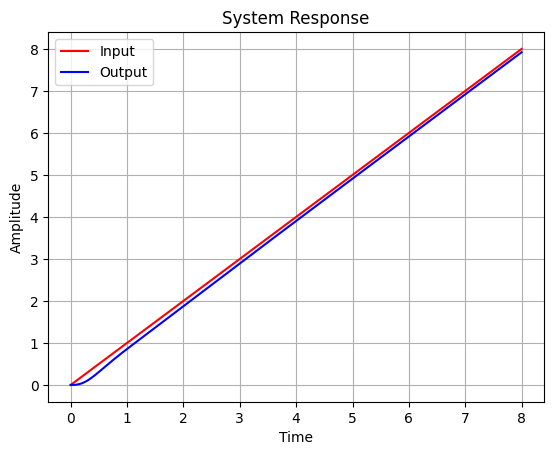

In [6]:
t = np.linspace(0, 8, 1000)

a_t = t

t_out, y_out = ct.forced_response(ct.feedback(gp*gc), T=t, U=a_t)

plt.plot(t, a_t, label='Input', c="r")
plt.plot(t_out, y_out, label='Output', c="b")
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('System Response')
plt.legend()
plt.grid(True)
plt.show()